# TMD 2024
### Lucas Poma
## Trabajo Practico 2

## Imports

In [ ]:
library(ggplot2)
library(rpart)
library(class)
library(MASS)
install.packages("caret")
library(caret)
install.packages("randomForest")
library(randomForest)
install.packages("kernlab")
library(kernlab)
install.packages("gridExtra")
library(gridExtra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: lattice

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘kernlab’


The following object is masked from ‘package:ggplot2’:

    alpha


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’



## Estimadores Error

In [ ]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
  invisible(capture.output(model <- ksvm(as.matrix(x.train), as.factor(y), type=type,kernel=kernel,C=C,cross = cross)))
  return ( model@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
  num.feat<-dim(x.train)[2]
  tot.problems<-nlevels(y)*(nlevels(y)-1)/2

  invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)))

  w<-rep(0.0,num.feat)
  for(i in 1:tot.problems) for(feat in 1:num.feat)
      w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
  rank.list<-sort(w,decreasing=FALSE,index=T)
  return(list(feats=rank.list$ix,imp=rank.list$x))
}

## Diagonales

In [ ]:
diagonales <- function(n, d, C) {
  half <- floor(n / 2)

  mClass0 <- rep(-1, d)
  mClass1 <- rep(1, d)
  covM <- diag(C^2 * d, d)

  class0 <- MASS::mvrnorm(n = half, mu = mClass0, Sigma = covM)
  class1 <- MASS::mvrnorm(n = n - half, mu = mClass1, Sigma = covM)

  labels0 <- matrix(0, nrow = half, ncol = 1)
  labels1 <- matrix(1, nrow = n - half, ncol = 1)

  data0 <- cbind(class0, labels0)
  data1 <- cbind(class1, labels1)

  data <- rbind(data0, data1)

  columns <- c(paste0("dim_", 1:d), "class")
  dataFrame <- as.data.frame(data)
  colnames(dataFrame) <- columns
  dataFrame$class <- as.factor(dataFrame$class)

  return(dataFrame)
}


## Ejercicio 1

In [ ]:
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1]

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",list.feat,"\n")
	}

 	return(list.feat)

}

In [ ]:
backward.ranking <- function(x, y, method, verbosity = 0, ...) {

  max.feat <- dim(x)[2]    # num de features
  list.feat <- 1:max.feat  # inicializo
  keep.feat <- double(max.feat)  # orden de las vars

  # removemos la feature menos importante hasta que quede 1
  while(length(list.feat) > 1){

    class.error <- double(length(list.feat))

    # entreno el modelo y calculo el error sin esa variable
    for(i in 1:length(list.feat)){
      x.train <- as.matrix(x[, list.feat[-i]])
      class.error[i] <- do.call(method, c(list(x.train, y), list(...)))
    }

    # vemos cual es la que genera el menor error
    worst.feat <- which.min(class.error)

    # emovemos la feature para la prox iteracion
    keep.feat[length(list.feat)] <- list.feat[worst.feat]
    list.feat <- list.feat[-worst.feat]

    if(verbosity > 1) {
      cat("\nStep ", max.feat - length(list.feat), "\nRemoved Feature: ", worst.feat, "\n")
    }
  }

  # la ultima feature es la mas importante
  keep.feat[1] <- list.feat

  return(keep.feat)
}

In [ ]:
kruskal.ranking <- function(x, y, verbosity = 0) {

  max.feat <- dim(x)[2]  # num de features
  p.values <- double(max.feat)  # guardo p-values

  # calculamos los p-values con Kruskal Wallis
  for (i in 1:max.feat) {
    p.values[i] <- kruskal.test(x[, i], y)$p.value

    if (verbosity > 1) {
      cat("Feature", i, "- p-value:", p.values[i], "\n")
    }
  }

  # rankeamos las features segun el p-value
  list.feat <- order(p.values)

  if (verbosity > 1) {
    cat("\nFinal ranking of features based on Kruskal-Wallis test:\n")
    cat("Features ranked (by index):", list.feat, "\n")
  }

  return(list.feat)
}

In [ ]:
rfe.ranking <- function(x, y, method, verbosity = 0, ...) {

  max.feat <- dim(x)[2]  # num de features
  list.feat <- 1:max.feat  # lista de features
  rank.list <- double(max.feat)  # ranking de features

  # removemos 1 feature por iteracion
  for (i in 1:max.feat) {
    # entrenamos el modelo usando las features que nos quedan
    x.train <- as.matrix(x[, list.feat])

    # rankeamos las features segun el metodo
    ranking <- do.call(method, c(list(x.train, y), list(...)))

    # obtenemos la menos importante
    last <- ranking$feats[1]

    # guardamos la menos importante en la lista de rankings y la sacamos de las restantes
    rank.list[max.feat - i + 1] <- list.feat[last]
    list.feat <- list.feat[-last]

    if (verbosity > 1) {
      cat("Step", i, "- Removed feature:", last, "\n")
    }
  }

  if (verbosity > 1) {
    cat("\nFinal ranking of features using RFE:\n")
    cat("Features ranked (by index):", rank.list, "\n")
  }

  return(rank.list)
}

## DataSets

In [ ]:
#---------------------------------------------------------------------------
#Codigo con datasets de ejemplo y para el TP2
#---------------------------------------------------------------------------
#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar

crea.ruido.unif<-function(n=100,d=2){
x<-runif(2*n*d,min=-1)	#genero los datos
dim(x)<-c(2*n,d)
return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con orden de importancia: 8-6-4-2
#---------------------------------------------------------------------------
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con dos variables relevantes (1-2) y dos variables que son importantes pero que no resuelven el problema (3-4)
#---------------------------------------------------------------------------
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

## Ejercicio 2

### Datos A

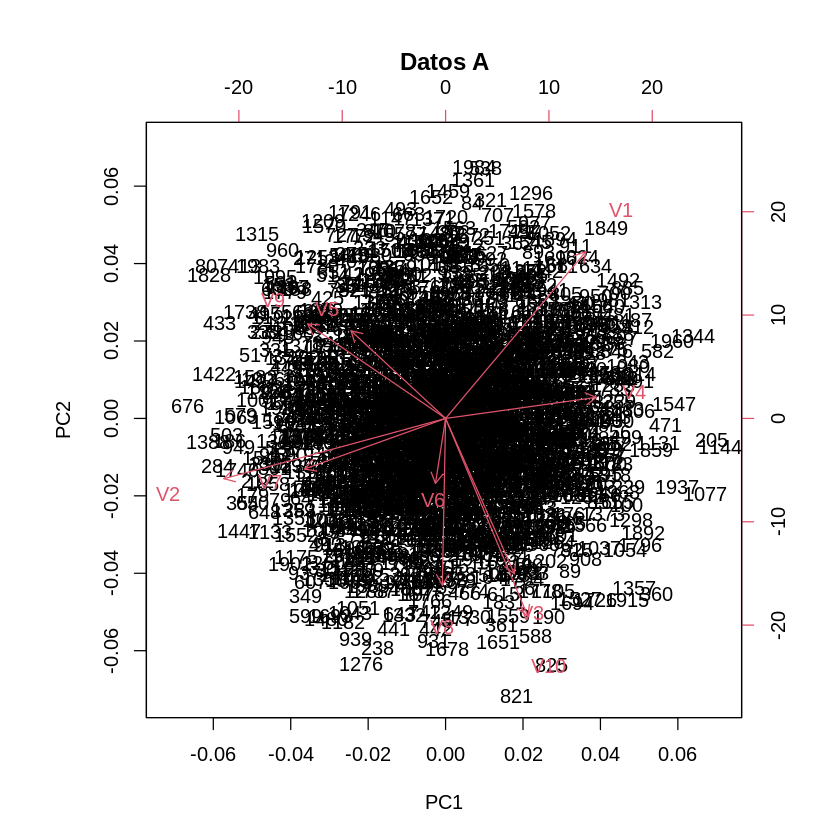

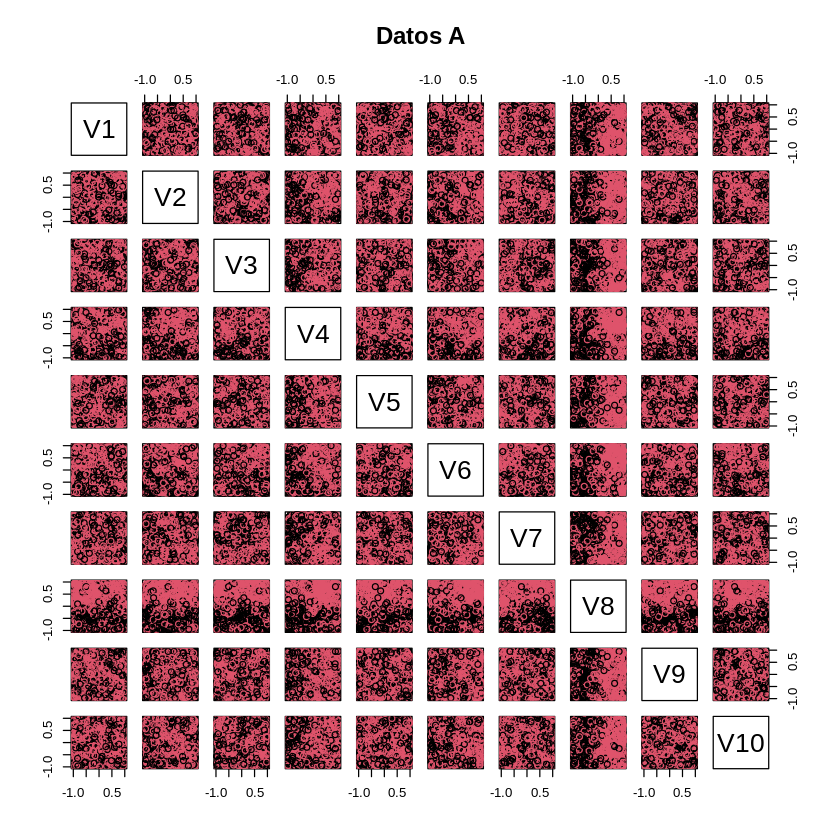

In [ ]:
datosA.x = datosA[,1:10]
datosA.y = datosA$y

datosA.pca<-prcomp(datosA.x, scale = T)
biplot(datosA.pca, main= "Datos A")
plot(datosA.x, col=datosA.y, main="Datos A")

#### Forward Ranking

In [ ]:
datosA.forward.rf <- forward.ranking(datosA.x, datosA.y, "rf.est")
datosA.forward.lda <- forward.ranking(datosA.x, datosA.y, "lda.est")
datosA.forward.svm <- forward.ranking(datosA.x, datosA.y, method="svm.est")

In [ ]:
cat("\n > Forward ranking RF \n")
datosA.forward.rf
cat("\n > Forward ranking LDA \n")
datosA.forward.lda
cat("\n > Forward ranking SVM \n")
datosA.forward.svm


 > Forward ranking RF 


[1]  8  6  1  7  2  5  3 10  9  4


 > Forward ranking LDA 


[1]  8  9 10  5  3  1  7  2  4  6


 > Forward ranking SVM 


[1]  8  5 10  3  9  7  1  4  2  6

#### Backward Ranking

In [ ]:
datosA.backward.rf = backward.ranking(datosA.x, datosA.y, "rf.est")
datosA.backward.lda = backward.ranking(datosA.x, datosA.y, "lda.est")
datosA.backward.svm <- backward.ranking(datosA.x, datosA.y, method="svm.est")

In [ ]:
cat("\n > Backward ranking RF \n")
datosA.backward.rf
cat("\n > Backward ranking LDA \n")
datosA.backward.lda
cat("\n > Backward ranking SVM \n")
datosA.backward.svm


 > Backward ranking RF 


[1]  8 10  9  5  1  2  3  7  6  4


 > Backward ranking LDA 


[1]  8  9 10  5  3  1  7  2  4  6


 > Backward ranking SVM 


[1]  8 10  7  3  1  5  4  9  2  6

#### Kruskall Wallice Ranking

In [ ]:
datosA.kruskal = kruskal.ranking(datosA.x, datosA.y)

In [ ]:
cat("\n > Kruskal ranking \n")
datosA.kruskal


 > Kruskal ranking 


[1]  8  6  4  2  7  5  3  1  9 10

#### RFE Ranking

In [ ]:
datosA.rfe.rf = rfe.ranking(datosA.x, datosA.y, "imp.rf")
datosA.rfe.linsvm <- rfe.ranking(datosA.x, datosA.y, method="imp.linsvm")

In [ ]:
cat("\n > RFE ranking RF \n")
datosA.rfe.rf
cat("\n > RFE ranking LINSVM \n")
datosA.rfe.linsvm


 > RFE ranking RF 


[1]  8  6  4  1  2  5  7 10  3  9


 > RFE ranking LINSVM 


[1]  8  6  4  2  7  5 10  9  1  3

#### Comentarios

Podemos observar que todos los métodos logran identificar correctamente que la variable más relevante es la número 8. Esto es coherente con la creación del dataset, donde la clase de la mitad de los datos depende del signo de esta variable. Tambien podemos observar la relevancia que toma V8 en el plot 2 a 2, donde vemos que logra una buena separación de clases con todas las otras variables. En el PCA V8 destaca por estar alineada verticalmente.

Sin embargo, solo los métodos Kruskal y RFE consiguen identificar otras variables que, aunque menos relevantes que la variable 8, siguen siendo importantes para determinar la clase. Los demás métodos, en cambio, muestran un rendimiento significativamente inferior en esta tarea.

### Datos B

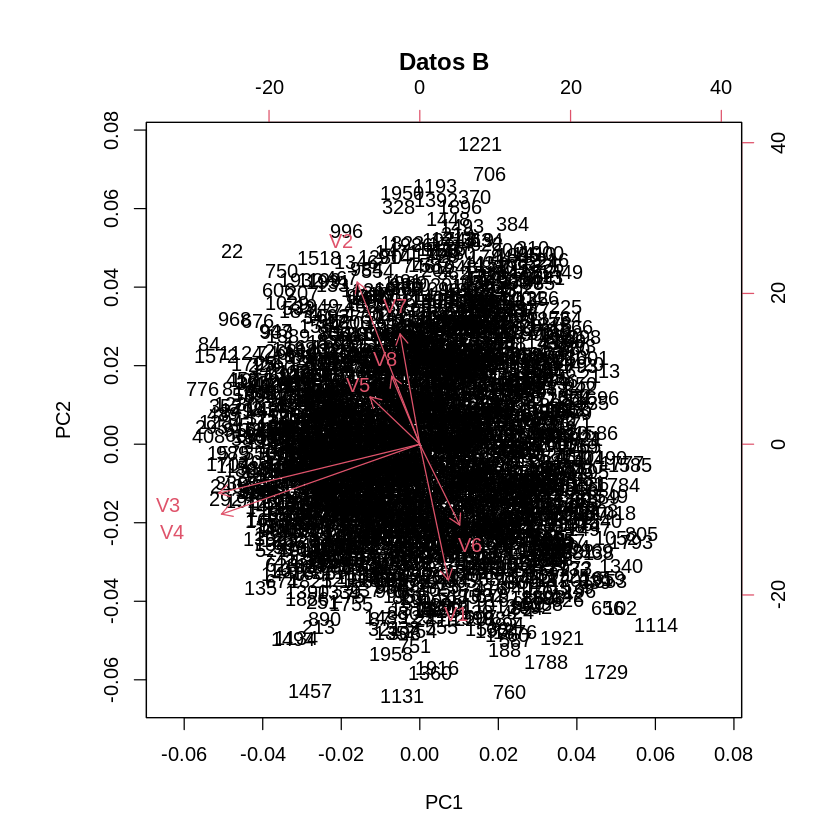

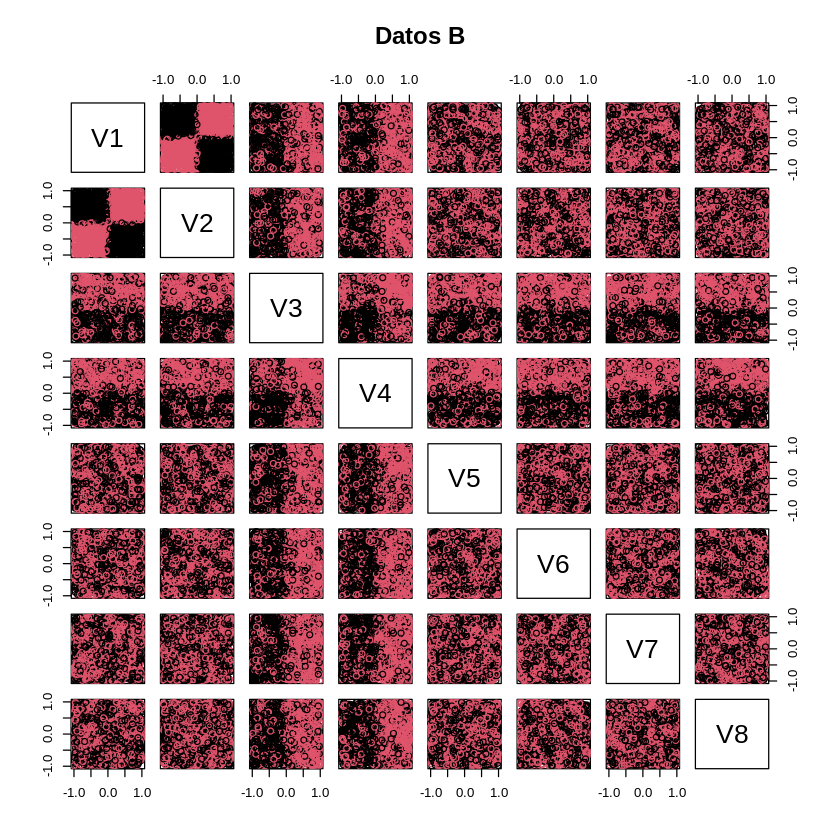

In [ ]:
datosB.x = datosB[,1:8]
datosB.y = datosB$y

datosB.pca<-prcomp(datosB.x, scale = T)
biplot(datosB.pca, main= "Datos B")
plot(datosB.x, col=datosB.y, main="Datos B")

#### Forward Ranking

In [ ]:
datosB.forward.rf <- forward.ranking(datosB.x, datosB.y, "rf.est")
datosB.forward.lda <- forward.ranking(datosB.x, datosB.y, "lda.est")
datosB.forward.svm <- forward.ranking(datosB.x, datosB.y, method="svm.est")

In [ ]:
cat("\n > Forward ranking RF \n")
datosB.forward.rf
cat("\n > Forward ranking LDA \n")
datosB.forward.lda
cat("\n > Forward ranking SVM \n")
datosB.forward.svm


 > Forward ranking RF 


[1] 4 3 6 7 5 8 1 2


 > Forward ranking LDA 


[1] 4 7 8 2 1 6 5 3


 > Forward ranking SVM 


[1] 4 6 8 1 2 5 7 3

#### Backward Ranking

In [ ]:
datosB.backward.rf <- backward.ranking(datosB.x, datosB.y, "rf.est")
datosB.backward.lda <- backward.ranking(datosB.x, datosB.y, "lda.est")
datosB.backward.svm <- backward.ranking(datosB.x, datosB.y, method="svm.est")

In [ ]:
cat("\n > Backward ranking RF \n")
datosB.backward.rf
cat("\n > Backward ranking LDA \n")
datosB.backward.lda
cat("\n > Backward ranking SVM \n")
datosB.backward.svm


 > Backward ranking RF 


[1] 1 2 5 8 6 7 3 4


 > Backward ranking LDA 


[1] 4 6 1 2 5 7 8 3


 > Backward ranking SVM 


[1] 4 6 7 8 1 5 3 2

#### Kruskall Wallice Ranking

In [ ]:
datosB.kruskal <- kruskal.ranking(datosB.x, datosB.y)

In [ ]:
cat("\n > Kruskal ranking \n")
datosB.kruskal


 > Kruskal ranking 


[1] 4 3 6 2 5 1 7 8

#### RFE Ranking

In [ ]:
datosB.rfe.rf <- rfe.ranking(datosB.x, datosB.y, "imp.rf")
datosB.rfe.linsvm <- rfe.ranking(datosB.x, datosB.y, method="imp.linsvm")

In [ ]:
cat("\n > RFE ranking RF \n")
datosB.rfe.rf
cat("\n > RFE ranking LINSVM \n")
datosB.rfe.linsvm


 > RFE ranking RF 


[1] 2 1 4 3 5 8 7 6


 > RFE ranking LINSVM 


[1] 4 3 6 2 7 1 8 5

#### Comentarios

En la creación del dataset, observamos que la clase depende del XOR entre las variables V1 y V2. Esto se puede ver claramente en el gráfico 2 a 2, donde se logra una separación casi perfecta de los datos entre estas dos variables. Además, V3 y V4, al tener cierta correlación con la clase, también muestran una separación notable en el gráfico 2 a 2. En el PCA, se observa que V3 y V4 tienden a agruparse, mientras que V1 y V2 se encuentran en posiciones opuestas, alineadas de manera vertical.

La mayoría de los métodos falla al identificar correctamente las variables más relevantes, destacando incorrectamente a V4 como la más importante cuando en realidad no lo es. Solo los métodos RFE y Backward, utilizando random forest, logran identificar correctamente a V1 y V2 como las variables más importantes.

## Ejercicio 3

In [ ]:
datosDiagRuido <- function() {
  # Generar el dataset con 50 puntos por clase y 10 variables
  datosDiag <- diagonales(100, 10, 2)

  # Agregar 90 variables de ruido (uniforme entre -1 y 1)
  n <- nrow(datosDiag)  # Número de filas (100 puntos en total)
  ruido <- matrix(runif(n * 90, min = -1, max = 1), nrow = n, ncol = 90)

  # Convertir el ruido a un data frame y asignar nombres de columnas
  colnames(ruido) <- paste0("r_", 1:90)

  # Combinar el dataset original con las variables de ruido
  datosDiag_ruido <- cbind(datosDiag[,-11], ruido, class = datosDiag[,11])

  return (datosDiag_ruido)
}

In [ ]:
# Inicializamos la matriz donde guardaremos los resultados
n_iters <- 30  # Número de iteraciones
p <- 10        # Número de características relevantes
results_matrix <- matrix(0, nrow = n_iters, ncol = 7)  # Matriz para almacenar rankings (7 métodos)

# Iteramos 30 veces
for (i in 1:n_iters) {
  # Generamos un nuevo conjunto de datos
  datos <- datosDiagRuido()
  datos.x <- datos[,-101]
  datos.y <- datos[,101]

  results_matrix[i, 1] <- sum(forward.ranking(datos.x, datos.y, "rf.est",tot.trees=100,equalize.classes=F)[1:10] <= p)
  results_matrix[i, 2] <- sum(forward.ranking(datos.x, datos.y, method="svm.est")[1:10] <= p)
  results_matrix[i, 3] <- sum(backward.ranking(datos.x, datos.y, "rf.est",tot.trees=100,equalize.classes=F)[1:10] <= p)
  results_matrix[i, 4] <- sum(backward.ranking(datos.x, datos.y, method="svm.est")[1:10] <= p)
  results_matrix[i, 5] <- sum(kruskal.ranking(datos.x, datos.y)[1:10] <= p)
  results_matrix[i, 6] <- sum(rfe.ranking(datos.x, datos.y, "imp.rf",tot.trees=100,equalize.classes=F)[1:10] <= p)
  results_matrix[i, 7] <- sum(rfe.ranking(datos.x, datos.y, method="imp.linsvm")[1:10] <= p)
  cat("Iteracion: ", i, "\n")
}

Iteracion:  1 
Iteracion:  2 
Iteracion:  3 
Iteracion:  4 
Iteracion:  5 
Iteracion:  6 
Iteracion:  7 
Iteracion:  8 
Iteracion:  9 
Iteracion:  10 
Iteracion:  11 
Iteracion:  12 
Iteracion:  13 
Iteracion:  14 
Iteracion:  15 
Iteracion:  16 
Iteracion:  17 
Iteracion:  18 
Iteracion:  19 
Iteracion:  20 
Iteracion:  21 
Iteracion:  22 
Iteracion:  23 
Iteracion:  24 
Iteracion:  25 
Iteracion:  26 
Iteracion:  27 
Iteracion:  28 
Iteracion:  29 
Iteracion:  30 


In [ ]:
columns <- c("F RF", "F SVM", "B RF", "B SVM", "K", "RFE RF", "RFE LINSVM")
dataFrame <- as.data.frame(results_matrix)
colnames(dataFrame) <- columns

dataFrame

F RF F SVM B RF B SVM K RFE RF RFE LINSVM
1  0    3     1    5     4 1      3         
2  2    3     0    2     3 2      1         
3  1    2     1    2     3 2      3         
4  2    3     0    2     5 5      2         
5  3    3     2    0     5 2      3         
6  0    1     0    2     3 2      4         
7  2    1     1    0     4 4      1         
8  0    2     1    1     3 1      1         
9  2    1     1    2     2 4      3         
10 2    1     2    1     2 1      2         
11 3    4     1    2     6 3      3         
12 2    1     0    2     3 0      2         
13 0    2     1    2     4 2      3         
14 0    0     1    1     2 3      1         
15 0    2     0    2     2 3      4         
16 1    2     1    1     4 3      1         
17 2    1     1    1     2 2      2         
18 1    3     0    3     2 2      1         
19 2    1     2    3     6 5      4         
20 0    3     3    3     3 2      1         
21 0    2     2    3     5 2      4         
22 2    1     1    0     4 1      3         
23 3    3     0    4     4 3      2         
24 0    2     1    2     7 5      4         
25 2    4     2    3     5 5      4         
26 0    0     1    0     4 1      3         
27 2    3     3    1     5 4      4         
28 2    1     2    2     4 3      4         
29 0    2     1    0     2 2      2         
30 0    1     0    2     3 2      1

In [17]:
max_value <- 10

accuracy <- colSums(dataFrame) / (max_value * n_iters)

accuracy_dataFrame <- as.data.frame(t(accuracy))

colnames(accuracy_dataFrame) <- colnames(dataFrame)

accuracy_dataFrame

F RF F SVM     B RF      B SVM K    RFE RF    RFE LINSVM
1 0.12 0.1933333 0.1066667 0.18  0.37 0.2566667 0.2533333

#### Comentarios

Probamos todos los métodos de ranking utilizando random forest y SVM, a excepción del filtro basado en Kruskal-Wallis. Podemos observar que, para este tipo de dataset en particular, existe una clara predominancia entre los diferentes métodos de selección de variables (en otra corrida obtuve resultados similares).

El orden de efectividad fue: Kruskal-Wallis > RFE SVM/RF > Forward/Backward SVM > Forward/Backward RF.

Además, al ser el método más rápido, el filtro no parametrizado de Kruskal-Wallis aporta un valor adicional, destacándose no solo por su precisión, sino también por su eficiencia.

## Ejercicio 4

Para este ejercicio, generé un dataset utilizando un script en Python que descarga los datos históricos (de todo este año 2024) de acciones e índices desde Yahoo Finance. En este dataset, las columnas representan los símbolos de las acciones o índices, excepto la primera columna, que corresponde al día (la cual descartamos posteriormente, ya que es solo un identificador). Cada entrada refleja la variación diaria del precio de cada símbolo.

Mi objetivo principal era identificar qué otros símbolos resultaban más importantes a la hora de predecir el movimiento en el precio de la acción de Banco Galicia (GGAL). Para esto, definí cinco clases que reflejan las posibles variaciones del precio: "bajó mucho" (menos del -2%), "bajó algo" (entre -2% y -0.5%), "neutro" (entre -0.5% y +0.5%), "subió un poco" (entre +0.5% y +2%) y "subió mucho" (más del +2%).

In [ ]:
stocksCSV <- read.csv('/content/daily_price_variation.csv')

In [ ]:
stocks <- stocksCSV[,-1]


stocks$GGAL <- cut(stocks$GGAL,
               breaks = c(-Inf, -0.02, -0.005, 0.005, 0.02, Inf),
               labels = c(-2, -1, 0, 1, 2),
               right = FALSE)  # Include the left interval, exclude the right

stocks$GGAL <- as.factor(stocks$GGAL)

stocks.x = stocks[,-ncol(stocks)]
stocks.y = stocks$GGAL

variable_names <- colnames(stocks.x)

head(stocks)

QQQ          SPY          EEM          EWZ          XLF         
1 -0.010581500 -0.008166597 -0.005535964  0.001745805 -0.008474472
2 -0.005146468 -0.003221094 -0.003289471 -0.010456117  0.004006451
3  0.001185979  0.001369654  0.001269327  0.011447018  0.004256501
4  0.020668007  0.014275917  0.002789037  0.002031358  0.006357537
5  0.001975510 -0.001517096 -0.014159198 -0.014190450 -0.006317374
6  0.006777564  0.005655449 -0.002308365 -0.001468922  0.001589359
  BAC           JPM          BRK.B        NU           VALE        
1 -0.0109146308 -0.004358288  0.011835813 -0.004920044 -0.005728883
2  0.0080526784  0.006636081 -0.008370845  0.018541362 -0.012163885
3  0.0186390248  0.005017217  0.005251880  0.040048536 -0.008425105
4 -0.0078419542 -0.001451160  0.007084429  0.037339634 -0.001960801
5 -0.0155153160 -0.007906053 -0.003476557  0.004499433 -0.022265887
6 -0.0008920814  0.002109475  0.002780102  0.016797269 -0.010716652
  VIST         MELI        IEF           EMB          AAAU         
1  0.056471434 -0.01906931  0.0023951354 -0.003855717 -0.0083374243
2 -0.021248382  0.01292000 -0.0060252626 -0.004553733  0.0009891424
3  0.010515651  0.01280124 -0.0036579717 -0.003087792  0.0000000000
4  0.021483698  0.02389479  0.0033565059  0.001261899 -0.0079051309
5 -0.031219216 -0.00143438 -0.0004179653 -0.003895566  0.0000000000
6 -0.005766624  0.01577540 -0.0015689669  0.007131348 -0.0019919825
  BTC.USD       GGAL
1 -0.0469281204 -1  
2  0.0310805786 -2  
3 -0.0003900068 1   
4  0.0688937834 1   
5 -0.0176871306 -2  
6  0.0105775840 2

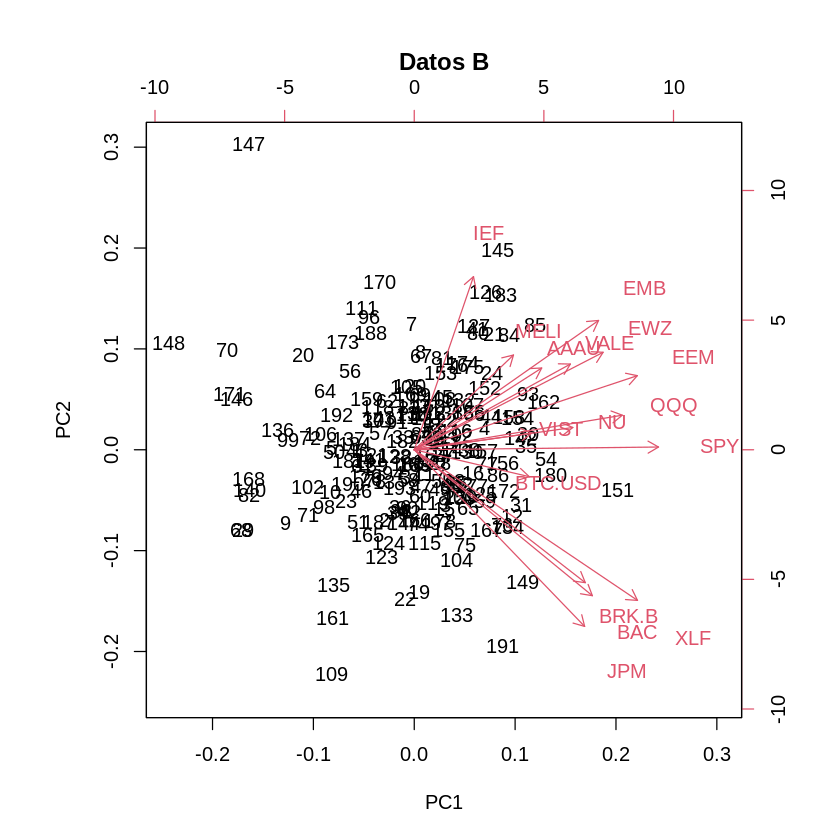

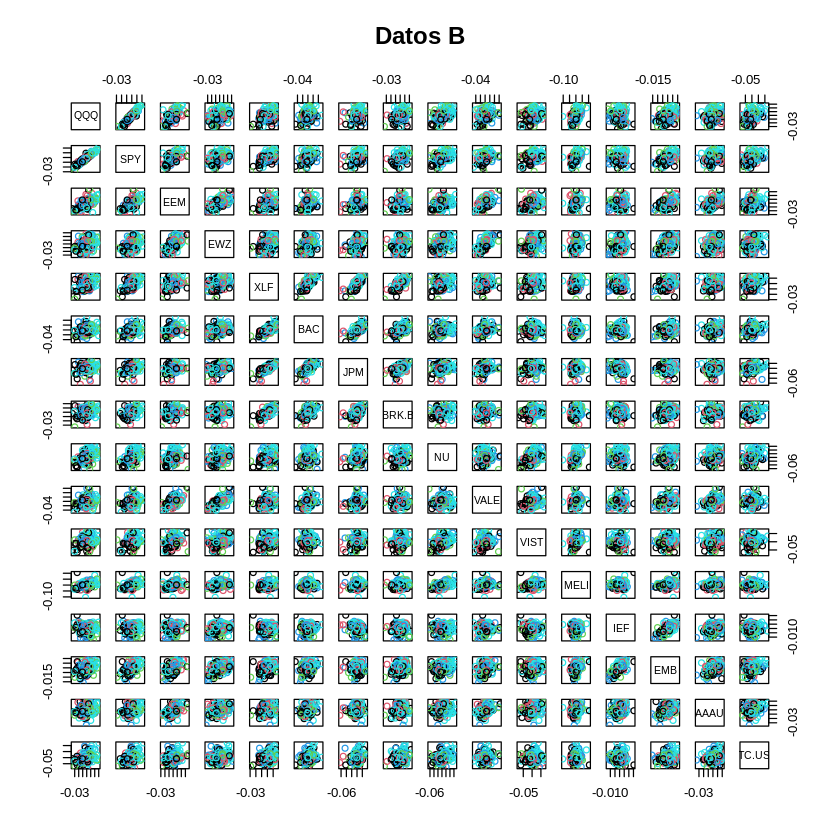

In [ ]:
stocks.pca<-prcomp(stocks.x, scale = T)
biplot(stocks.pca, main= "Datos B")
plot(stocks.x, col=stocks.y, main="Datos B")

Al analizar el PCA, observé que la entrada 147 parecía ser un outlier, ya que estaba muy alejada del resto de los datos. Debido a esto, decidí removerla.

Esto mejoró notablemente la dispersión en el gráfico, haciendo más claras y definidas las agrupaciones. Por lo tanto, considero que la decisión de eliminar esta entrada fue acertada.

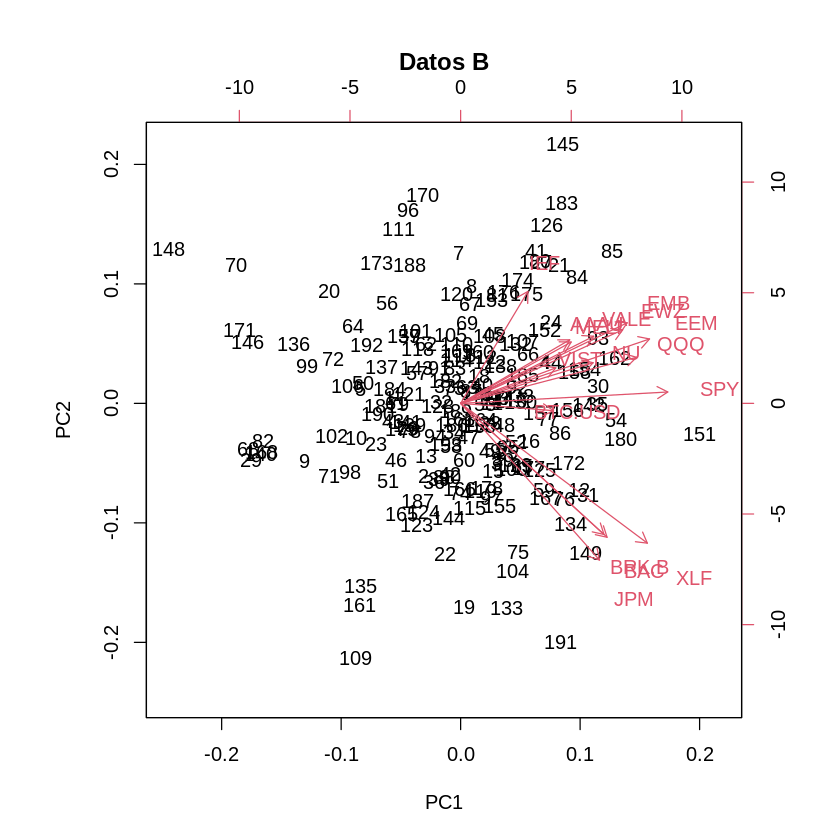

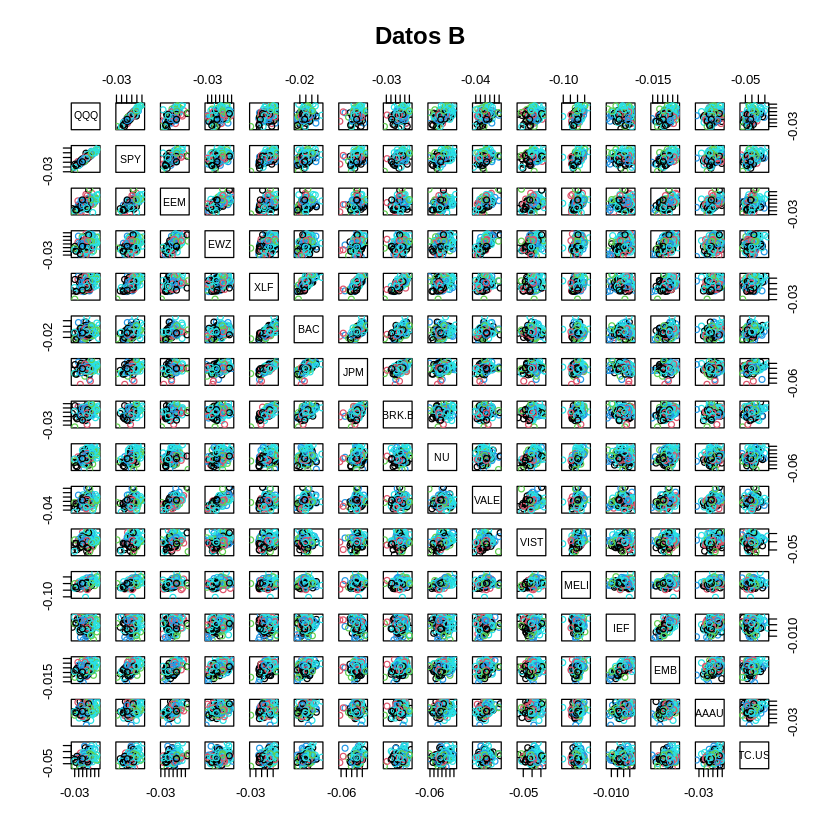

In [ ]:
stocks.x = stocks[-147,-ncol(stocks)]
stocks.y = stocks[-147,]$GGAL

stocks.pca<-prcomp(stocks.x, scale = T)
biplot(stocks.pca, main= "Datos B")
plot(stocks.x, col=stocks.y, main="Datos B")

Resultó interesante ver reflejado en los resultados lo que ya suponía acerca de las correlaciones entre variables y las agrupaciones en el PCA. Por ejemplo, se observa una marcada correlación entre los índices QQQ (Nasdaq) y SPY (S&P500), lo cual tiene sentido, ya que ambos comparten muchas empresas en su composición y son los principales referentes del mercado estadounidense. Además, ambos índices muestran cierta correlación con EEM (Emerging Markets).

Por otro lado, se destaca la agrupación de entidades financieras como JPMorgan, Bank of America, Berkshire Hathaway y el índice del sector financiero. Asimismo, el índice bursátil de Brasil, EWZ, se agrupa con dos de las empresas que lo componen: NUBank y Vale.

Finalmente, se observa una relación entre los bonos estadounidenses (IEF) y los bonos de mercados emergentes (EMB), lo que también es consistente con sus dinámicas en los mercados globales.

### Rankings

#### Forward Ranking

In [ ]:
stocks.forward.rf <- forward.ranking(stocks.x, stocks.y, "rf.est")
stocks.forward.lda <- forward.ranking(stocks.x, stocks.y, "lda.est")
stocks.forward.svm <- forward.ranking(stocks.x, stocks.y, method="svm.est")

In [ ]:
stocks.forward.rf.names <- variable_names[stocks.forward.rf]
stocks.forward.lda.names <- variable_names[stocks.forward.lda]
stocks.forward.svm.names <- variable_names[stocks.forward.svm]

cat("\n > Forward ranking RF (Variable Names) \n")
print(stocks.forward.rf.names)

cat("\n > Forward ranking LDA (Variable Names) \n")
print(stocks.forward.lda.names)

cat("\n > Forward ranking SVM (Variable Names) \n")
print(stocks.forward.svm.names)


 > Forward ranking RF (Variable Names) 
 [1] "VIST"    "EMB"     "JPM"     "NU"      "QQQ"     "BTC.USD" "IEF"    
 [8] "BAC"     "EEM"     "XLF"     "SPY"     "VALE"    "MELI"    "BRK.B"  
[15] "AAAU"    "EWZ"    

 > Forward ranking LDA (Variable Names) 
 [1] "VIST"    "EMB"     "JPM"     "AAAU"    "VALE"    "BTC.USD" "EWZ"    
 [8] "SPY"     "BRK.B"   "QQQ"     "EEM"     "BAC"     "MELI"    "XLF"    
[15] "NU"      "IEF"    

 > Forward ranking SVM (Variable Names) 
 [1] "VIST"    "EMB"     "AAAU"    "BAC"     "BRK.B"   "NU"      "EEM"    
 [8] "IEF"     "MELI"    "VALE"    "SPY"     "QQQ"     "JPM"     "XLF"    
[15] "EWZ"     "BTC.USD"


#### Backward Ranking

In [ ]:
stocks.backward.rf <- backward.ranking(stocks.x, stocks.y, "rf.est")
stocks.backward.lda <- backward.ranking(stocks.x, stocks.y, "lda.est")
stocks.backward.svm <- backward.ranking(stocks.x, stocks.y, method="svm.est")

In [ ]:
stocks.backward.rf.names <- variable_names[stocks.backward.rf]
stocks.backward.lda.names <- variable_names[stocks.backward.lda]
stocks.backward.svm.names <- variable_names[stocks.backward.svm]

cat("\n > Backward ranking RF (Variable Names) \n")
print(stocks.backward.rf.names)

cat("\n > Backward ranking LDA (Variable Names) \n")
print(stocks.backward.lda.names)

cat("\n > Backward ranking SVM (Variable Names) \n")
print(stocks.backward.svm.names)


 > Backward ranking RF (Variable Names) 
 [1] "VIST"    "MELI"    "BAC"     "BTC.USD" "JPM"     "NU"      "IEF"    
 [8] "SPY"     "AAAU"    "VALE"    "EWZ"     "EMB"     "XLF"     "EEM"    
[15] "BRK.B"   "QQQ"    

 > Backward ranking LDA (Variable Names) 
 [1] "VIST"    "EMB"     "QQQ"     "SPY"     "EEM"     "BAC"     "IEF"    
 [8] "AAAU"    "VALE"    "MELI"    "XLF"     "NU"      "JPM"     "EWZ"    
[15] "BRK.B"   "BTC.USD"

 > Backward ranking SVM (Variable Names) 
 [1] "VIST"    "MELI"    "BTC.USD" "VALE"    "EEM"     "SPY"     "EMB"    
 [8] "BRK.B"   "IEF"     "BAC"     "EWZ"     "QQQ"     "AAAU"    "XLF"    
[15] "NU"      "JPM"    


#### Kruskall Wallice Ranking

In [ ]:
stocks.kruskal <- kruskal.ranking(stocks.x, stocks.y)

In [ ]:
stocks.kruskal.names <- variable_names[stocks.kruskal]

cat("\n > Kruskal ranking \n")
print(stocks.kruskal.names)


 > Kruskal ranking 
 [1] "VIST"    "EMB"     "SPY"     "QQQ"     "EEM"     "MELI"    "NU"     
 [8] "IEF"     "XLF"     "EWZ"     "BAC"     "JPM"     "BRK.B"   "BTC.USD"
[15] "AAAU"    "VALE"   


#### RFE Ranking

In [ ]:
stocks.rfe.rf <- rfe.ranking(stocks.x, stocks.y, "imp.rf")
stocks.rfe.linsvm <- rfe.ranking(stocks.x, stocks.y, method="imp.linsvm")

In [ ]:
stocks.rfe.rf.names <- variable_names[stocks.rfe.rf]
stocks.rfe.linsvm.names <- variable_names[stocks.rfe.linsvm]

cat("\n > RFE ranking RF (Variable Names) \n")
print(stocks.rfe.rf.names)

cat("\n > RFE ranking LINSVM (Variable Names) \n")
print(stocks.rfe.linsvm.names)


 > RFE ranking RF (Variable Names) 
 [1] "VIST"    "EEM"     "QQQ"     "SPY"     "EMB"     "BAC"     "JPM"    
 [8] "NU"      "EWZ"     "IEF"     "BTC.USD" "MELI"    "XLF"     "BRK.B"  
[15] "AAAU"    "VALE"   

 > RFE ranking LINSVM (Variable Names) 
 [1] "VIST"    "QQQ"     "SPY"     "EMB"     "VALE"    "XLF"     "EEM"    
 [8] "NU"      "MELI"    "JPM"     "EWZ"     "IEF"     "BTC.USD" "BAC"    
[15] "AAAU"    "BRK.B"  


Todos los métodos clasificaron a VIST (Vista Energy) como la variable más importante, lo cual es lógico, ya que tanto VIST como GGAL están radicadas en Argentina y, por lo tanto, están expuestas al mismo riesgo idiosincrático del país.

También resultan relevantes los índices QQQ (Nasdaq) y EMB (Emerging Market Bonds). Esto tiene sentido, ya que QQQ últimamente ha sido un marcador clave de la economía mundial, mientras que EMB proporciona un contexto importante sobre la deuda argentina.

Lo que me sorprendió fue que XLF (índice del sector financiero) y EWZ (índice de acciones de Brasil) no hayan sido clasificados mucho más alto, considerando el riesgo inherente al sector financiero y la relevancia regional de Brasil.

Interesantes resultados.
NO ES RECOMENDACION DE COMPRA!!